In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import io

# import seaborn as sns

In [9]:
def check_data(df, expected_columns, expected_dtypes):
    assert set(df.columns) == set(
        expected_columns), "Les colonnes ne correspondent pas aux attentes."
    for col, dtype in expected_dtypes.items():
        assert df[col].dtype == dtype, f"Le type de données pour {col} n'est pas {dtype}."


# Vérifier les colonnes et les types de données après transformation
expected_columns = ['CustomerID','Recency','Frequency','Monetary']
expected_dtypes = {
    'CustomerID': 'float64',
    'Recency': 'int64',
    'Frequency': 'int64',
    'Monetary': 'float64'
}

# Extraction des Données

In [8]:
# Chemin vers le fichier Excel
file_path = 'Online Retail.xlsx'
# Chargement du fichier Excel dans un DataFrame
with io.open(file_path, 'r', encoding='utf-8') as f:
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
        # Affichez les premières lignes pour vérifier si le chargement s'est bien déroulé
        print(df.head())
        # Afficher les types de données de chaque colonne
        print(df.dtypes)
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier Excel : {e}")
# Affichage des premières lignes du DataFrame
#print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerI

### Nettoyage des données
soustraction des valeurs négatives de la colonne Quantity

In [4]:
# Extraction des lignes avec des quantités positives
positive_quantities = df[df['Quantity'] >= 0]

# Suppression des colonnes inutiles
positive_quantities = positive_quantities.drop(
    columns=['StockCode', 'Description', 'Country'])

# Exportation des données dans un fichier CSV
positive_quantities.to_csv('positive_quantities.csv', index=False)

# Transformation des données
Création d'un nouveau dataframe issus de regroupement par client avec la récence, la somme des dépenses par client et la fréquence d'achat par client en fonction de la date de référence.

In [10]:
# Formatage de la colonne InvoiceDate en datetime
positive_quantities['InvoiceDate'] = pd.to_datetime(
    positive_quantities['InvoiceDate'])

# Calculer le montant total par transaction
positive_quantities['TotalPrice'] = positive_quantities['UnitPrice'] * \
    positive_quantities['Quantity']

# Calcul de la récence, fréquence et montant
reference_date = pd.to_datetime('2010-12-01')
# Calculer la récence
recency = positive_quantities.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days
}).rename(columns={'InvoiceDate': 'Recency'})
# Calculer la fréquence
frequency = positive_quantities.groupby('CustomerID').agg({
    'InvoiceDate': 'nunique'
}).rename(columns={'InvoiceDate': 'Frequency'})
# Calculer le montant
monetary = positive_quantities.groupby('CustomerID').agg({
    'TotalPrice': 'sum'
}).rename(columns={'TotalPrice': 'Monetary'})
# Combiner les trois métriques en un seul DataFrame
rfm = recency.join(frequency).join(monetary).reset_index()

# Verification des données
check_data(rfm, expected_columns, expected_dtypes)

# Affichage des premières lignes du DataFrame
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      -49          1  77183.60
1     12347.0     -372          7   4310.00
2     12348.0     -299          4   1797.24
3     12349.0     -356          1   1757.55
4     12350.0      -64          1    334.40


### Utilisation du machine learning pour segmenter les clients (k-mean)

Exception in thread Thread-34 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in po

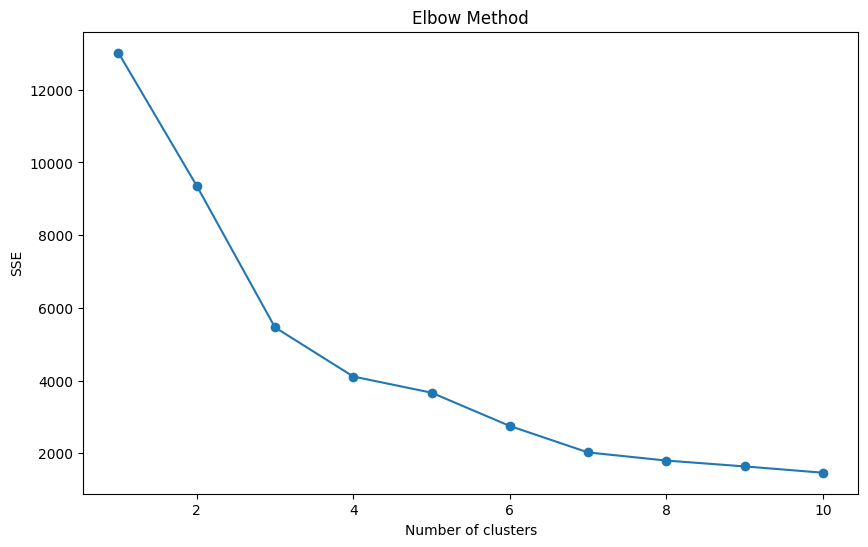

In [11]:
# Préparer les données pour le clustering
rfm_data = rfm[['Recency', 'Frequency', 'Monetary']]
# Standardiser les données
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)
# Appliquer K-means avec le nombre optimal de clusters
optimal_clusters = 5
# Initialiser K-means
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
# Prédire les clusters
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
# Mapper les numéros de clusters aux noms significatifs
cluster_names = {
    0: 'Champions',
    1: 'Clients Fidèles',
    2: 'Grands Dépenseurs',
    3: 'Clients potentiellement fidèles'
}
# Appliquer le mapping des noms aux clusters
rfm['Cluster Name'] = rfm['Cluster'].map(cluster_names)
print(rfm.head())
# Exporter les données avec les clusters
rfm.to_csv('rfm_online_retail.csv', index=False)

# Afficher les statistiques des clusters
cluster_aggregates = rfm.groupby('Cluster Name').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).reset_index()
# Afficher les résultats de l'analyse des clusters
print(cluster_aggregates)
# Exporter les résultats de l'analyse des clusters
cluster_aggregates.to_csv('cluster_aggregates_online_retail.csv', index=False)

   CustomerID  Recency  Frequency  Monetary  Cluster        Cluster Name
0     12346.0      -49          1  77183.60        0           Champions
1     12347.0     -372          7   4310.00        3  Clients Potentiels
2     12348.0     -299          4   1797.24        3  Clients Potentiels
3     12349.0     -356          1   1757.55        3  Clients Potentiels
4     12350.0      -64          1    334.40        1     Clients Fidèles
         Cluster Name     Recency  Frequency       Monetary
0           Champions -359.166667  21.861905   12444.119905
1     Clients Fidèles -125.826579   1.551367     478.194732
2  Clients Potentiels -330.512275   3.647463    1353.643219
3   Grands Dépenseurs -367.384615  81.846154  127338.313846


In [13]:
cluster_aggregates = cluster_aggregates.sort_values(
    by='Monetary', ascending=False)
print(cluster_aggregates)

         Cluster Name     Recency  Frequency       Monetary
3   Grands Dépenseurs -367.384615  81.846154  127338.313846
0           Champions -359.166667  21.861905   12444.119905
2  Clients Potentiels -330.512275   3.647463    1353.643219
1     Clients Fidèles -125.826579   1.551367     478.194732
